In [4]:
import torch
import matplotlib.pyplot as plt
from gatys import  image_loader, imshow, run_style_transfer
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
from style_transfer_net import StyleTransferNet
from dataloader import create_dataloader
import numpy as np


## Load images

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [7]:
test_style_img = "/Users/Hippolyte/Desktop/MVA/Image generation/AdaIN-Project/data/wikiart_small/nicholas-roerich_tibet-1933-1.jpg"
test_content_img = "/Users/Hippolyte/Desktop/MVA/Image generation/AdaIN-Project/data/val2017/000000581357.jpg"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


content_img = image_loader(loader,test_content_img,device)
style_img = image_loader(loader,test_style_img,device)

print(content_img.size(),style_img.size())

if content_img.size()[2]*content_img.size()[3] > style_img.size()[2]*style_img.size()[3]:
    print("resizing")
    resized_content_img = transforms.functional.crop(content_img,0,0,style_img.size()[2],style_img.size()[3])
    resized_style_img = style_img
    print(resized_content_img.size(),style_img.size())
elif content_img.size()[2]*content_img.size()[3] < style_img.size()[2]*style_img.size()[3]:
    print("resizing")
    resized_style_img = transforms.functional.crop(style_img,0,0,content_img.size()[2],content_img.size()[3])
    resized_content_img = content_img
    print(content_img.size(),style_img.size())

assert resized_style_img.size() == resized_content_img.size(), \
    "For Gatys, we need to import style and content images of the same size"

torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 214])
resizing
torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 214])


## Tests on Gatys et al Neural-Style algorithm

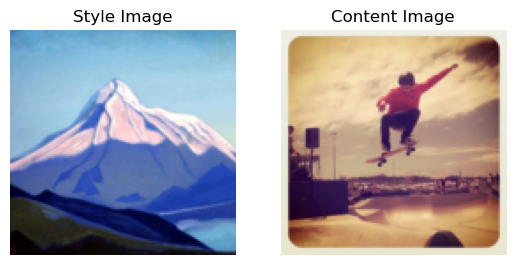

In [8]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

fig, ax = plt.subplots(1,2)
imshow(ax[0],resized_style_img,unloader, title='Style Image')
imshow(ax[1], resized_content_img,unloader, title='Content Image')

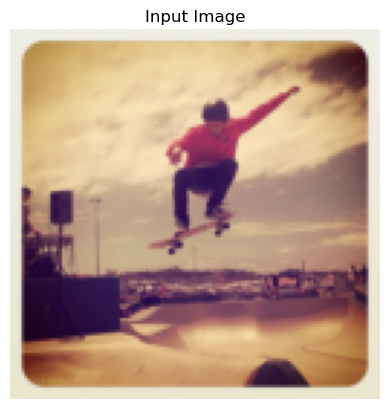

In [9]:
input_img = resized_content_img.clone()
# if you want to use white noise by using the following code:
#
# .. code-block:: python
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
fig, ax = plt.subplots(1,1)
imshow(ax, input_img, unloader, title='Input Image')

In [13]:
original_model = vgg19(weights=VGG19_Weights.DEFAULT)
original_model.named_parameters

<bound method Module.named_parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256

In [7]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            resized_content_img, resized_style_img, input_img, num_steps=10000)


Building the style transfer model..


/Users/Hippolyte/anaconda3/envs/nlp/lib/python3.11/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 577.981445 Content Loss: 27.122551

run [100]:
Style Loss : 176.104218 Content Loss: 27.322701

run [150]:
Style Loss : 87.680305 Content Loss: 27.827736

run [200]:
Style Loss : 56.042191 Content Loss: 27.790125

run [250]:
Style Loss : 39.363354 Content Loss: 27.518190

run [300]:
Style Loss : 30.175426 Content Loss: 27.052485

run [350]:
Style Loss : 24.083784 Content Loss: 26.421860

run [400]:
Style Loss : 20.055777 Content Loss: 25.839674

run [450]:
Style Loss : 17.067055 Content Loss: 25.280014

run [500]:
Style Loss : 14.520479 Content Loss: 24.838900

run [550]:
Style Loss : 12.278860 Content Loss: 24.369905

run [600]:
Style Loss : 10.581354 Content Loss: 23.930208

run [650]:
Style Loss : 9.080956 Content Loss: 23.494137

run [700]:
Style Loss : 8.039845 Content Loss: 23.245230

run [750]:
Style Loss : 7.310090 Content Loss: 22.825808

run [800]:
Style Loss : 6.925651 Content Loss: 22.560387

run [850]:
Style Loss : 7.075740 Content Loss:

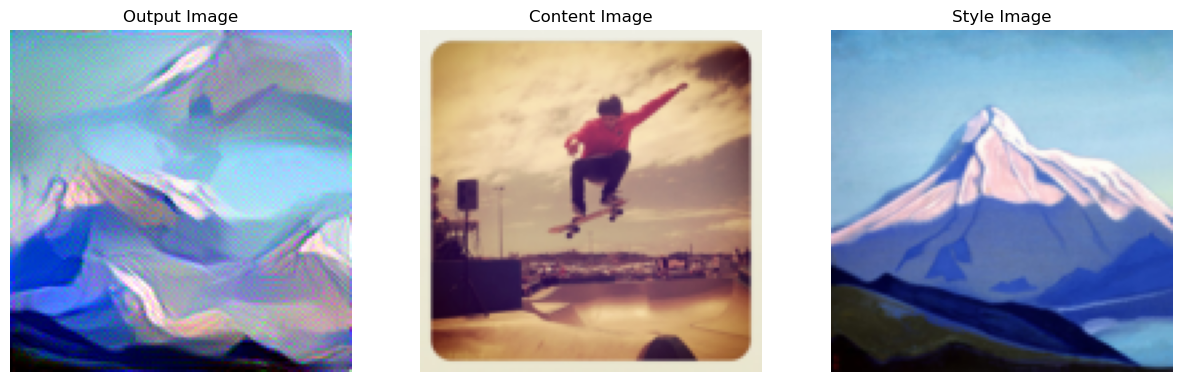

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
imshow(ax[0], output, unloader, title='Output Image')
imshow(ax[1], resized_content_img,unloader, title='Content Image')
imshow(ax[2], resized_style_img,unloader, title='Style Image')
plt.show()

## AdaIN style transfer

In [ ]:
model = StyleTransferNet(skip_connections=False).to(device)
    
model_path = 'models/...' 
model.decoder.load_state_dict(torch.load(model_path, map_location=device))

content_testloader, style_testloader = create_dataloader(test_content_imgs, test_style_imgs, trainset=False, batch_size=1, shuffle=False)

model.eval()
with torch.no_grad():
    for content_batch, style_batch in zip(content_testloader, style_testloader):
        content_batch = content_batch.to(device)
        style_batch = style_batch.to(device)

        styled_images = model(content_batch, style_batch)
        
        content_img = content_batch[0].detach().cpu().numpy().transpose(1, 2, 0)
        content_img = np.clip(content_img, 0, 1)  # Ensure the image is in the 0-1 range
        
        style_img = style_batch[0].detach().cpu().numpy().transpose(1, 2, 0)
        style_img = np.clip(style_img, 0, 1)  # Ensure the image is in the 0-1 range
        
        # Display the styled images
        styled_img = styled_images[0].detach().cpu().numpy().transpose(1, 2, 0)
        styled_img = np.clip(styled_img, 0, 1)  # Ensure the image is in the 0-1 range
        
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(content_img)
        ax[0].set_title('Content Image')
        ax[0].axis('off')
        ax[1].imshow(style_img)
        ax[1].set_title('Style Image')
        ax[1].axis('off')
        ax[2].imshow(styled_img)
        ax[2].set_title('Model output')
        ax[2].axis('off')
        plt.show()